# RGI-07: Region 13

F. Maussion & S. Galos, June 2021

In [1]:
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
import subprocess
import numpy as np
from utils import mkdir

### specify RGI-region and storage paths

In [2]:
# Region of interest
reg = 13

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '13_rgi60_CentralAsia.zip')

In [3]:
# Region is based on GAMDAM, use for comparison
support_dir = os.path.join(data_dir, 'l0_support_data')
gamdam_dir = os.path.join(support_dir, 'gamdam')

# Region file to select from gamdam
reg_file = os.path.join(data_dir, 'l0_regions', '00_rgi70_regions', '00_rgi70_O1Regions.shp')

### Load the input data

In [4]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### Apply selection criteria to create the RGI-07 data subset

In [5]:
# try to get the data relevant for RGI07 and select by attributes
rgi7 = shp.loc[shp['analysts'] == 'Sakai, Akiko']

## Write out and tar 

In [6]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI13.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI13'], returncode=0)


## New RGI-file created - Check result!

### load reference data (here GAMDAM original) to enable comparison

In [7]:
# specify path to reference data set
import zipfile
import glob
gam_files = glob.glob(gamdam_dir + '/*.zip')
df_ref = []
for gf in gam_files:
    # Just to know the name of the file to open from zip
    with zipfile.ZipFile(gf, "r") as z:
        for f in z.filelist:
            if '.shp' in f.filename:
                fname = f.filename
    df_ref.append(gpd.read_file('zip://' + gf + '/' + fname))

df_ref = pd.concat(df_ref).reset_index()

In [8]:
# Calculate representative points for reference data
ref_rp = df_ref.representative_point()

# Make a dataframe out of it and add the original index to recover it later
ref_rp = ref_rp.to_frame('geometry')
ref_rp['orig_index'] = df_ref.index

In [9]:
# Read region file
reg_f = gpd.read_file(reg_file)

In [10]:
# Make the overlay with the RGI region of interest -> get the rep. points which are located inside the region boundaries
ref_intersect = gpd.overlay(ref_rp, reg_f.loc[reg_f.RGI_CODE == f'{reg:02d}'], how='intersection')

In [11]:
# Now select the entries which intersect from the original shape file (-> extract the polygons) 
df_ref = df_ref.loc[ref_intersect['orig_index'].values].copy()

## Compare new RGI-file and reference data set 

### Number of elements (differences do not necessarily depict major problems)

In [12]:
print('Number of glaciers in new RGI subset:', len(rgi7))
print('Number of glaciers in reference data:', len(df_ref))
print('Difference:', len(rgi7)-len(df_ref))

Number of glaciers in new RGI subset: 75420
Number of glaciers in reference data: 75615
Difference: -195


### Total area

In [13]:
# add an area field to the selected GAMDAM table
df_ref['area'] = df_ref.to_crs({'proj':'cea'}).area

In [14]:
# print and compare area values
Area_RGI = rgi7['area'].sum() * 1e-6
print('Area RGI [km²]:', Area_RGI)
Area_ref = df_ref['area'].sum() * 1e-6
print('Area Ref [km²]:', Area_ref)
d = (Area_RGI - Area_ref)
print('Area difference [km²]:',d)

Area RGI [km²]: 50344.57044713261
Area Ref [km²]: 50341.698431230056
Area difference [km²]: 2.872015902554267


**We believe that remaining errors are of the same type as Region 01: multipolygons that weren't properly ingested in GLIMS.** We will check this below.

### Comparison with RGI6 

In [15]:
# Just to know the name of the file to open from zip
import zipfile
with zipfile.ZipFile(rgi6_reg_file, "r") as z:
    for f in z.filelist:
        if '.shp' in f.filename:
            fname = f.filename

# load reference data
rgi6 = gpd.read_file('zip://' + rgi6_reg_file + '/' + fname)

In [16]:
print('Number of glaciers in new RGI subset:', len(rgi7))
print('Number of glaciers in RGI6 data:', len(rgi6))
print('Difference:', len(rgi7)-len(rgi6))

Number of glaciers in new RGI subset: 75420
Number of glaciers in RGI6 data: 54429
Difference: 20991


In [17]:
rgi6['area'] = rgi6.to_crs({'proj':'cea'}).area

In [18]:
# print and compare area values
Area_RGI = rgi7['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_RGI)
Area_ref = rgi6['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_ref)
d = (Area_RGI - Area_ref)
print('Area difference [km²]:',d)

Area RGI7 [km²]: 50344.57044713261
Area RGI6 [km²]: 49303.4521764017
Area difference [km²]: 1041.1182707309126


# End of revised notebook

## Find missing glaciers 

In [19]:
from utils import haversine
import progressbar

In [20]:
def xy_coord(geom):
    """To compute CenLon CenLat ourselves"""
    x, y = geom.xy
    return x[0], y[0]

In [21]:
# compute CenLon CenLat ourselves
rp = df_ref.representative_point()

coordinates = np.array(list(rp.apply(xy_coord)))
df_ref['CenLon'] = coordinates[:, 0]
df_ref['CenLat'] = coordinates[:, 1]

In [22]:
df_ref_orig = df_ref.copy()

In [49]:
# Loop over all RGI7 glaciers and find their equivalent in ref
df_ref = df_ref_orig.copy()
not_found = {}
to_drop = []
for i, (ref_area, lon, lat) in progressbar.progressbar(enumerate(zip(rgi7['area'].values, rgi7.CenLon.values, rgi7.CenLat.values)), max_value=len(rgi7)):
#     dist = haversine(lon, lat, df_ref.CenLon.values, df_ref.CenLat.values)
    dist = (lon - df_ref.CenLon.values)**2 + (lat - df_ref.CenLat.values)**2 
    found = False
    for j in np.argsort(dist)[:10]:
        s6 = df_ref.iloc[j]
        if np.allclose(s6['area'], ref_area, rtol=0.001):
            found = True
            to_drop.append(s6.name)
            break
    if not found:
        not_found[i] = df_ref.iloc[np.argsort(dist)[:10]]
    if len(to_drop) > 1000:
        df_ref.drop(labels=to_drop, inplace=True)
        to_drop = []
df_ref.drop(labels=to_drop, inplace=True)

100% (75420 of 75420) |##################| Elapsed Time: 0:03:02 Time:  0:03:02


In [50]:
print(len(not_found), len(df_ref))

209 408


In [51]:
pb_rgi7 = rgi7.iloc[list(not_found.keys())]

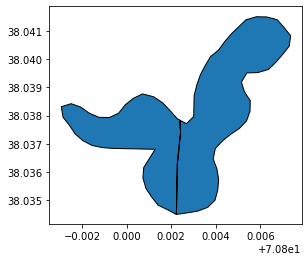

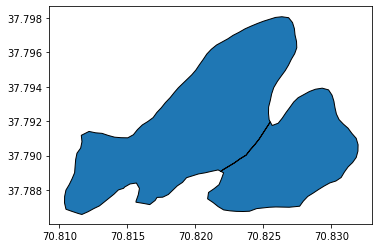

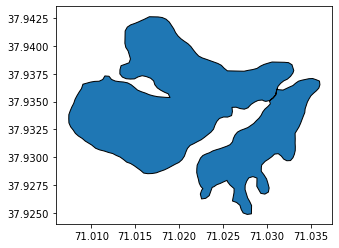

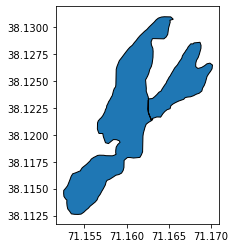

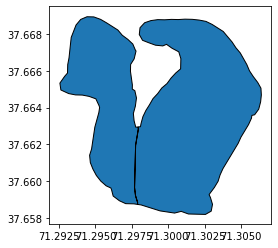

In [52]:
for i, k in enumerate(not_found.keys()):
    ax = rgi7.iloc[[k]].plot(edgecolor='k');
    if i > 3:
        break

In [53]:
# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_problem_glaciers'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_problem_glaciers_tar'))

In [54]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
pb_rgi7.to_file(dd + f'RGI{reg:02d}_glims.shp')
df_ref.to_file(dd + f'RGI{reg:02d}_ref.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_problem_glaciers_tar/RGI13.tar.gz', '-C', '../../rgi7_data/l3_problem_glaciers', 'RGI13'], returncode=0)
